<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Lab 5: Transfer Learning for Image Classification
</div>


becasue only gray scale, so we clone 2 into 3 img


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Welcome to this tutorial! Here, we'll explore the process of training a Convolutional Neural Network (CNN) for image classification through the powerful technique of transfer learning. To gain a deeper understanding of transfer learning, consider reviewing the comprehensive [cs231n notes](https://cs231n.github.io/transfer-learning/).

#### The Essence of Transfer Learning

A common challenge in training CNNs is the requirement for a large and diverse dataset. However, not every project or task has the luxury of such a dataset. This is where transfer learning becomes invaluable. In transfer learning, we leverage a pre-trained model— a model trained on a vast dataset, like ImageNet—and adapt it for a different, often more specific task.

#### Key Transfer Learning Scenarios

There are two primary approaches to using a pre-trained model in transfer learning:

1. **Finetuning the ConvNet:**
   - **Process:** Start with a pre-trained model and fine-tune it for a specific task.
   - **Initialization:** We initialize the model with the weights of a pre-trained network, ensuring a strong and relevant foundation.
   - **Training:** The model is then trained further on the new, specific dataset. It adapts and refines the pre-existing knowledge to fit the new data and task at hand.

2. **ConvNet as Fixed Feature Extractor:**
   - **Process:** Use the pre-trained model as a feature extractor and only train a new classifier on top of it.
   - **Frozen Layers:** All the layers of the pre-trained model, except the final fully connected layer, are frozen. Their weights remain unchanged.
   - **New Layer:** The final layer is replaced with a new one, initialized with random weights. This layer is then trained on the new dataset.
   - **Result:** The model harnesses the features learned from the large dataset and combines them with the specific learnings from the new data.

In [ ]:
# # Download dataset
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy

--2023-11-01 12:33:29--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy’

normal.npy          100%[===================>]  62.50M   368MB/s    in 0.2s    

2023-11-01 12:33:31 (368 MB/s) - ‘normal.npy’ saved [65536128/65536128]

--2023-11-01 12:33:31--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

## A. Data Loading and Preprocessing

Use PyTorch  [`Tensor.repeat()`](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html) to change the number of channels from 1 to 3.


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float().unsqueeze(1).repeat(1, 3, 1, 1) # 3 for channel
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float().unsqueeze(1).repeat(1, 3, 1, 1)
y_val = torch.from_numpy(y_val).long()

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)


In [ ]:
# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


## B. Defining Neural Networks

### 1. Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.

### 2. ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.models import list_models

import numpy as np
all_models = list_models()
all_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [ ]:
import os
import json
import torch
import matplotlib.pyplot as plt

class ModelData():

    def __init__(self, name, dataset_name):
        ''' 使用範例:
            md_data = ModelData(name="Model", dataset_name=[""])
            md_data.model_path="/content/drive"
            md_data.add_data(epoch=0, loss=0.5)
            md_data.reset_data(time=str(datetime.datetime.now()))
            md_data.save_data()
        '''
        self.model_data_dic = {}
        self.reset_data(name=name, dataset_name=dataset_name)
        self.model_path = "."

    def reset_path_and_folder(self, model_path):
        os.makedirs(model_path, exist_ok=True)
        self.model_path = model_path

    def reset_data(self, **kwargs):
        for kwarg, value in kwargs.items():
            setattr(self, kwarg, value)  # 設置實例的屬性
            self.model_data_dic[kwarg] = value  # 更新 self.model_data_dic 字典

    def add_data(self, **kwargs):
        for kwarg, value in kwargs.items():
            setattr(self, kwarg, value)
            if kwarg in self.model_data_dic and isinstance(self.model_data_dic[kwarg], list):
                self.model_data_dic[kwarg].append(value)
            else:
                self.model_data_dic[kwarg] = [value]

    def save_data(self, path=None, name=None):
        if path is None:
            path = self.model_path
        if name is None:
            name = self.name

        # 確保目錄存在，如果不存在則創建
        os.makedirs(path, exist_ok=True)

        file_path = f"{path}/{name}.json"
        existing_model_list = []

        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                existing_model_list = json.load(f)

        existing_model_list.append(self.model_data_dic)

        with open(file_path, 'w') as f:
            json.dump(existing_model_list, f, indent=4)

        print(f"Successfully dumped data into {file_path}")

    def read_data(self, model_name_list, model_root_path, mode="wm"):
        existing_model_list = []
        weight_list = []

        for name in model_name_list:
            if not name:  # Skip empty names
                continue

            file_path = f"{model_root_path}/{name}/{name}.json"  # 使用 model_root_path
            weight_path = f"{model_root_path}/{name}/{name}.pth"  # 使用 model_root_path

            print(f"Trying to read JSON from: {file_path}")  # 調試信息
            print(f"Trying to read weights from: {weight_path}")  # 調試信息

            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    existing_model_list.append(json.load(f))
            else:
                print(f"File {file_path} does not exist.")

            if os.path.exists(weight_path):
                weight_list.append(torch.load(weight_path))
            else:
                print(f"Weight file {weight_path} does not exist.")

        if mode == "w":
            return weight_list
        if mode == "m":
            return existing_model_list
        else:
            return weight_list, existing_model_list

    def compare_images(self, existing_model_list):
        for model_data in existing_model_list:
            for each_model_data in model_data:
                fig, ax = plt.subplots(1, 2, figsize=(15, 5))

                # Plotting training and validation accuracy
                ax[0].plot(each_model_data["train_accuracies"])
                ax[0].plot(each_model_data["val_accuracies"])
                ax[0].set_title(f'{each_model_data["name"]} Accuracy')
                ax[0].set_xlabel('Epochs')
                ax[0].set_ylabel('Accuracy')
                ax[0].legend(['Train', 'Val'])

                # Plotting training and validation loss
                ax[1].plot(each_model_data["train_losses"])
                ax[1].plot(each_model_data["val_losses"])
                ax[1].set_title(f'{each_model_data["name"]} Loss')
                ax[1].set_xlabel('Epochs')
                ax[1].set_ylabel('Loss')
                ax[1].legend(['Train', 'Val'])

                plt.show()

    def change_data(self, data_path, key, value):
        if os.path.exists(data_path):
            # 讀取現有的數據
            with open(data_path, 'r') as f:
                total_data = json.load(f)

            # 修改數據
            for i in total_data:
                i[key] = value

            # 寫回文件
            with open(data_path, 'w') as f:
                json.dump(total_data, f, indent=4)

In [ ]:
md_data = ModelData(name="efficientnet_b4_freeze", dataset_name=["https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy","https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy"])
md_data.reset_path_and_folder(f"/content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW4/Model/{md_data.name}")

import datetime
traning_times = []

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

#first method
# 1st model
# model = models.resnet18(weights='IMAGENET1K_V1')

# 2nd model
model = models.densenet121(pretrained=True)

# 3rd model
# model = models.efficientnet_b4()

# second method
# ConvNet as fixed feature extractor (freeze parameters)
# for param in model.parameters():
#     param.requires_grad = True # 前面全部會freeze，僅會train最後一個layer


# last layer type: fc
# num_ftrs = model.fc.in_features

# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# model.fc = nn.Linear(num_ftrs, 2)

# # #last layer type: classfier
num_ftrs = model.classifier.in_features
# # # Replace the last layer for binary classification
model.classifier = nn.Linear(num_ftrs, 2)

# last layer type: Sequential
# num_ftrs = model.classifier[-1].in_features
# # Replace the last layer for binary classification
# model.classifier[-1] = nn.Linear(num_ftrs, 2)

model = model.cuda()
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 50.8MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## C. Training the Neural Network

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30

# Change you model here
# model = ConvGAP()
# print(model)
# model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), f'{md_data.model_path}/{md_data.name}.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    training_time = str(datetime.datetime.now())
    traning_times.append(training_time)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.4462, Train acc: 83.31%, Val loss: 0.7957, Val acc: 50.00%, Best Val loss: 0.7957 Best Val acc: 50.00%
Epoch 2/30, Train loss: 0.2616, Train acc: 89.56%, Val loss: 4.1751, Val acc: 85.25%, Best Val loss: 0.7957 Best Val acc: 85.25%
Epoch 3/30, Train loss: 0.2633, Train acc: 89.62%, Val loss: 0.6836, Val acc: 77.00%, Best Val loss: 0.6836 Best Val acc: 85.25%
Epoch 4/30, Train loss: 0.2183, Train acc: 91.62%, Val loss: 0.1865, Val acc: 93.00%, Best Val loss: 0.1865 Best Val acc: 93.00%
Epoch 5/30, Train loss: 0.1821, Train acc: 93.12%, Val loss: 0.2102, Val acc: 91.25%, Best Val loss: 0.1865 Best Val acc: 93.00%
Epoch 6/30, Train loss: 0.1249, Train acc: 95.62%, Val loss: 0.2552, Val acc: 91.25%, Best Val loss: 0.1865 Best Val acc: 93.00%
Epoch 7/30, Train loss: 0.1616, Train acc: 94.06%, Val loss: 0.9422, Val acc: 72.00%, Best Val loss: 0.1865 Best Val acc: 93.00%
Epoch 8/30, Train loss: 0.1195, Train acc: 96.00%, Val loss: 0.1810, Val acc: 94.50%, Best Val lo

### Visualizing model performance

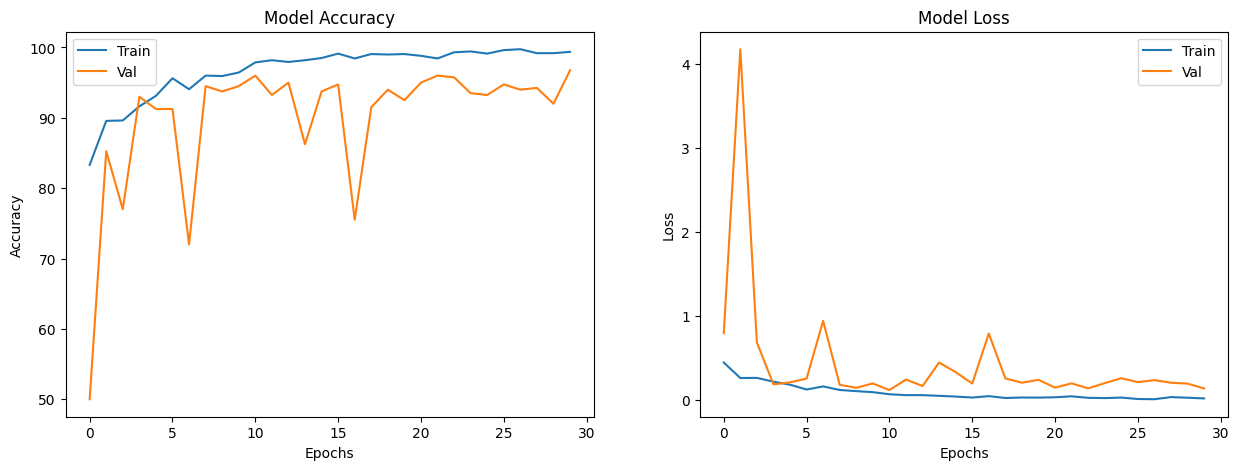

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [ ]:
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy

--2023-11-01 12:47:56--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13107328 (12M) [application/octet-stream]
Saving to: ‘test_normal.npy’

test_normal.npy     100%[===================>]  12.50M  --.-KB/s    in 0.07s   

2023-11-01 12:47:57 (174 MB/s) - ‘test_normal.npy’ saved [13107328/13107328]

--2023-11-01 12:47:57--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

### Process Test Dataset

In [ ]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).float().unsqueeze(1).repeat(1, 3, 1, 1)
y_test = torch.from_numpy(y_test).long()

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


In [ ]:
# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, 32, shuffle=False)

### Load Trained Model and Evaluate

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load(f'{md_data.model_path}/{md_data.name}.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
total_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        predicted = outputs.argmax(-1)
        test_correct += (predicted.float() == labels).sum().item()
        test_total += labels.size(0)

test_avg_loss = total_loss / len(test_loader)
test_accuracy = 100. * test_correct / test_total

print(f'test_avg_loss: {test_avg_loss}')
print(f'Test accuracy is {test_accuracy}%.')

test_avg_loss: 1.8506686331462474
Test accuracy is 75.25%.


In [ ]:
md_data.reset_data(train_losses=train_losses, val_losses=val_losses, train_accuracies=train_accuracies, val_accuracies=val_accuracies, traning_times=traning_times)
md_data.reset_data(model=str(model))
md_data.reset_data(test_data=["https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy","https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy"])
md_data.reset_data(test_avg_loss=test_avg_loss, test_accuracy=test_accuracy)
md_data.save_data()

Successfully dumped data into /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW4/Model/efficientnet_b4_freeze/efficientnet_b4_freeze.json


Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW4/Model/resnet18_IMAGENET1K_V1/resnet18_IMAGENET1K_V1.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW4/Model/resnet18_IMAGENET1K_V1/resnet18_IMAGENET1K_V1.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW4/Model/resnet18_IMAGENET1K_V1_freeze/resnet18_IMAGENET1K_V1_freeze.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW4/Model/resnet18_IMAGENET1K_V1_freeze/resnet18_IMAGENET1K_V1_freeze.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW4/Model/densenet121_pretrained/densenet121_pretrained.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW4/Model/densenet121_pretrained/densenet121_pretrained.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW4/Model/densenet121_pretrained_freeze/densenet121_pretrained_freeze.json
Trying to read weights from: /content/driv

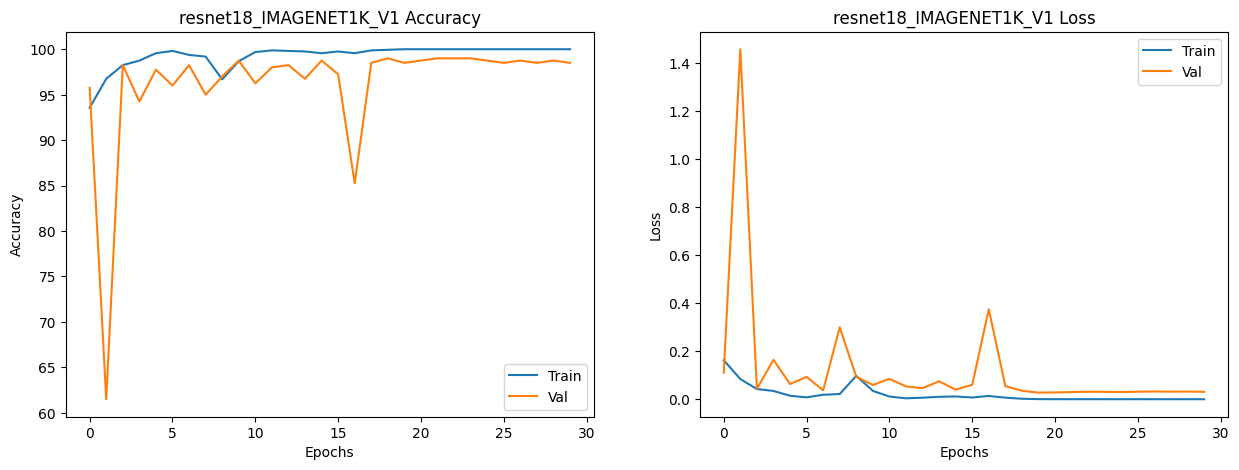

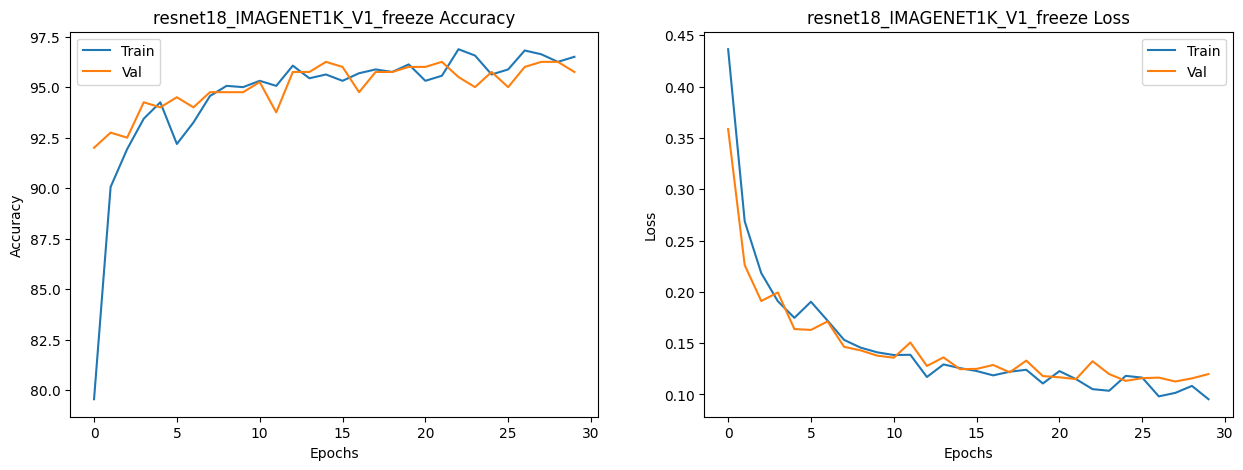

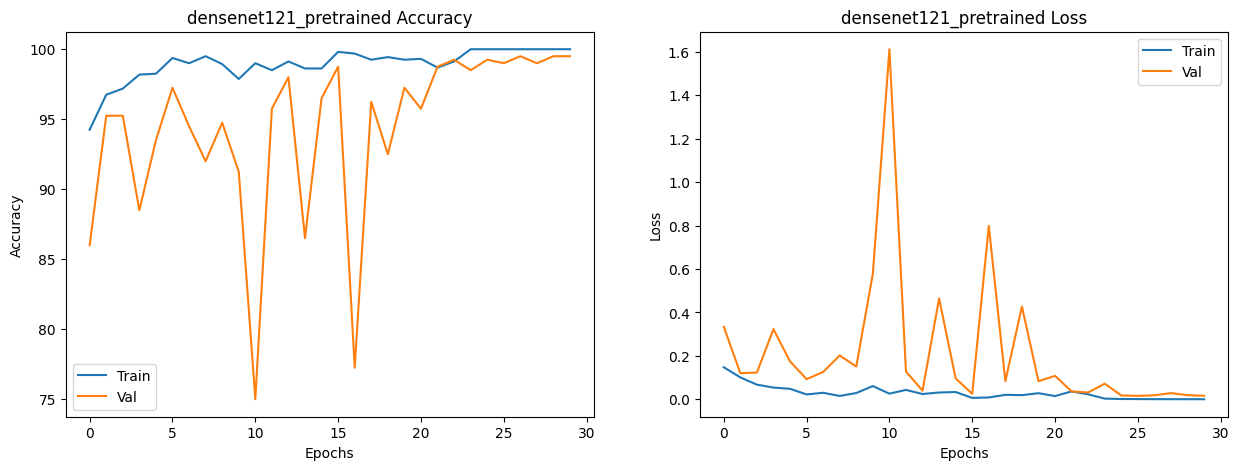

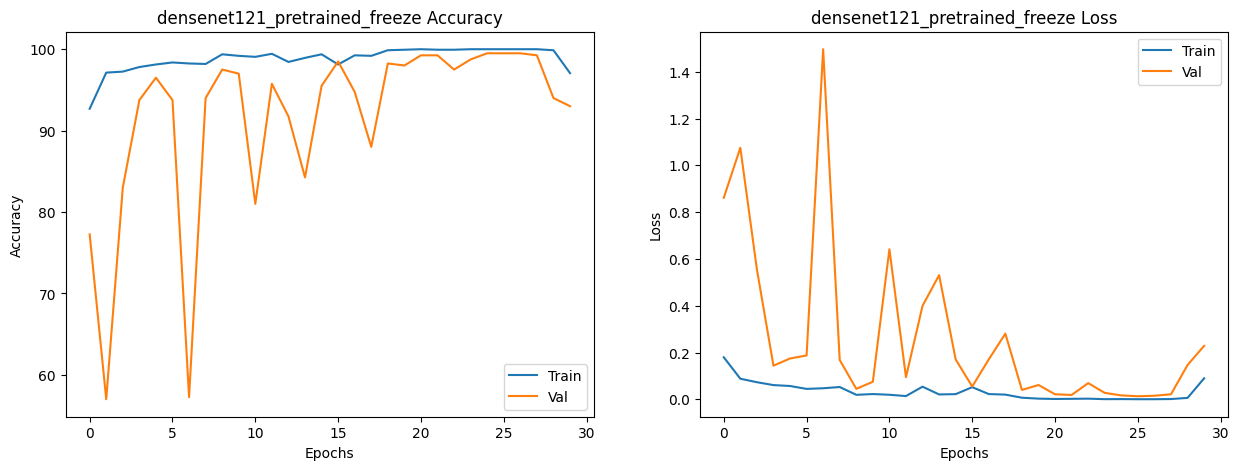

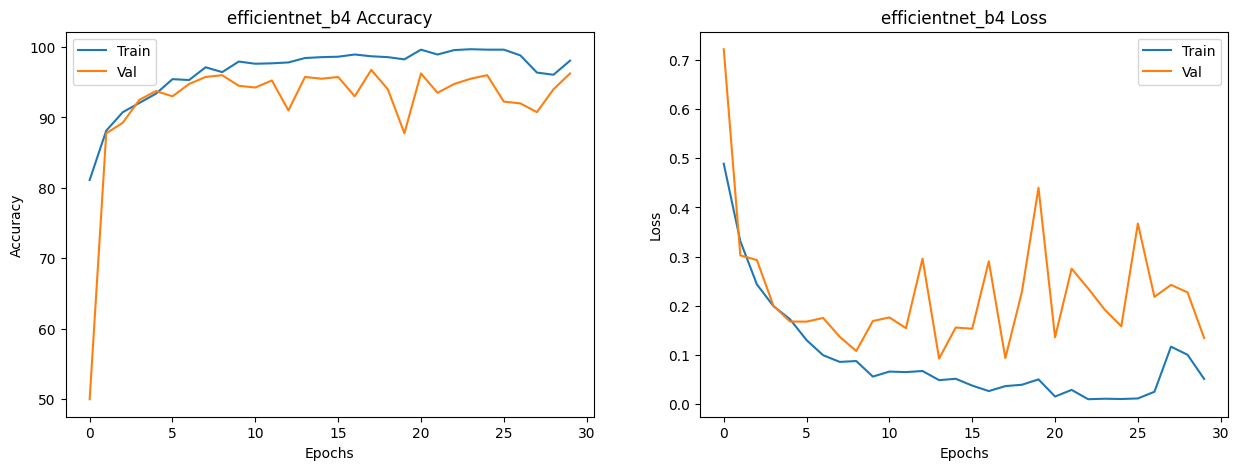

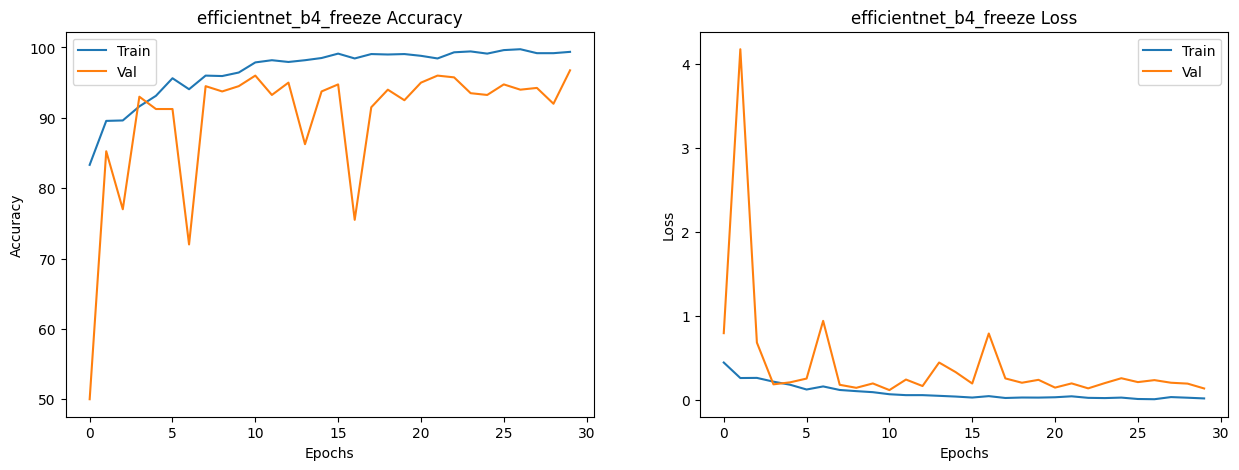

In [ ]:
model_name_list = ['resnet18_IMAGENET1K_V1', 'resnet18_IMAGENET1K_V1_freeze', 'densenet121_pretrained', 'densenet121_pretrained_freeze',
                   'efficientnet_b4', 'efficientnet_b4_freeze']

model_root_path = f"/content/drive/MyDrive/Course/研一上/深度學習之於生醫/HW4/Model"
weight_list, existing_model_list = md_data.read_data(model_name_list, model_root_path, mode="wm")
md_data.compare_images(existing_model_list)

In [ ]:
for mds in existing_model_list:
    for md in mds:
        print(f"{md['name']} ")
        print(f"test_avg_loss is {md['test_avg_loss']}")
        print(f"test_accuracy is {md['test_accuracy']}")

resnet18_IMAGENET1K_V1 
test_avg_loss is 1.497456060702881
test_accuracy is 76.75
resnet18_IMAGENET1K_V1_freeze 
test_avg_loss is 0.409200606151269
test_accuracy is 84.25
densenet121_pretrained 
test_avg_loss is 1.4183753639307235
test_accuracy is 78.25
densenet121_pretrained_freeze 
test_avg_loss is 1.3533543890826667
test_accuracy is 78.25
efficientnet_b4 
test_avg_loss is 0.9883250797597262
test_accuracy is 71.0
efficientnet_b4_freeze 
test_avg_loss is 1.8506686331462474
test_accuracy is 75.25
